# Automate Image Classification

follow the steps :
- change Runtime type to **GPU**
- Run the first cell

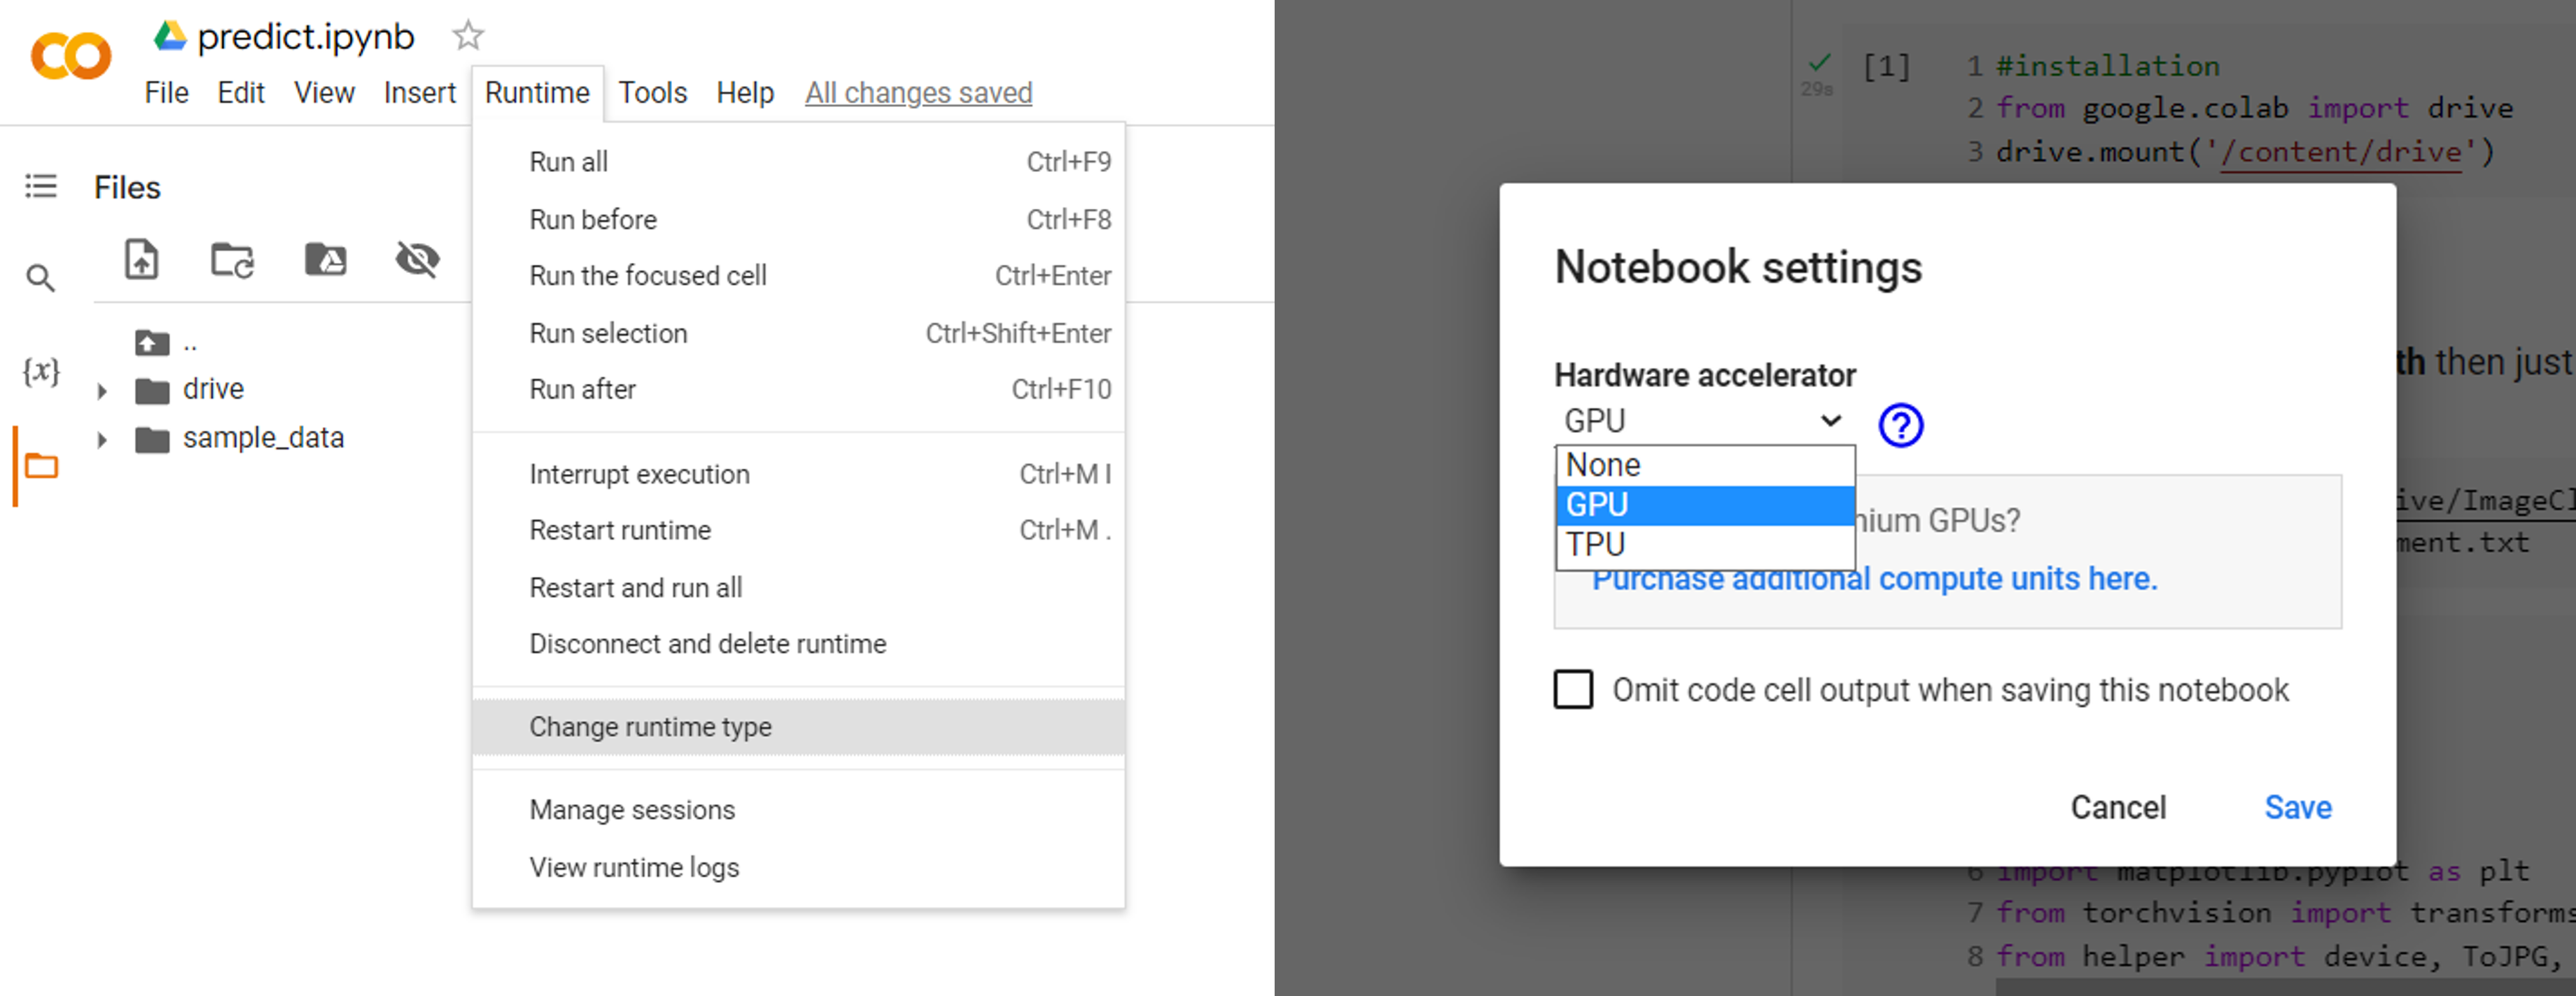

In [ ]:
#installation
from google.colab import drive
drive.mount('/content/drive' ,force_remount=True)

## Change your **Google drive path**
- then click for refresh
- go to your folder then copy folder path
- replace your path in the next cell
- then just click run

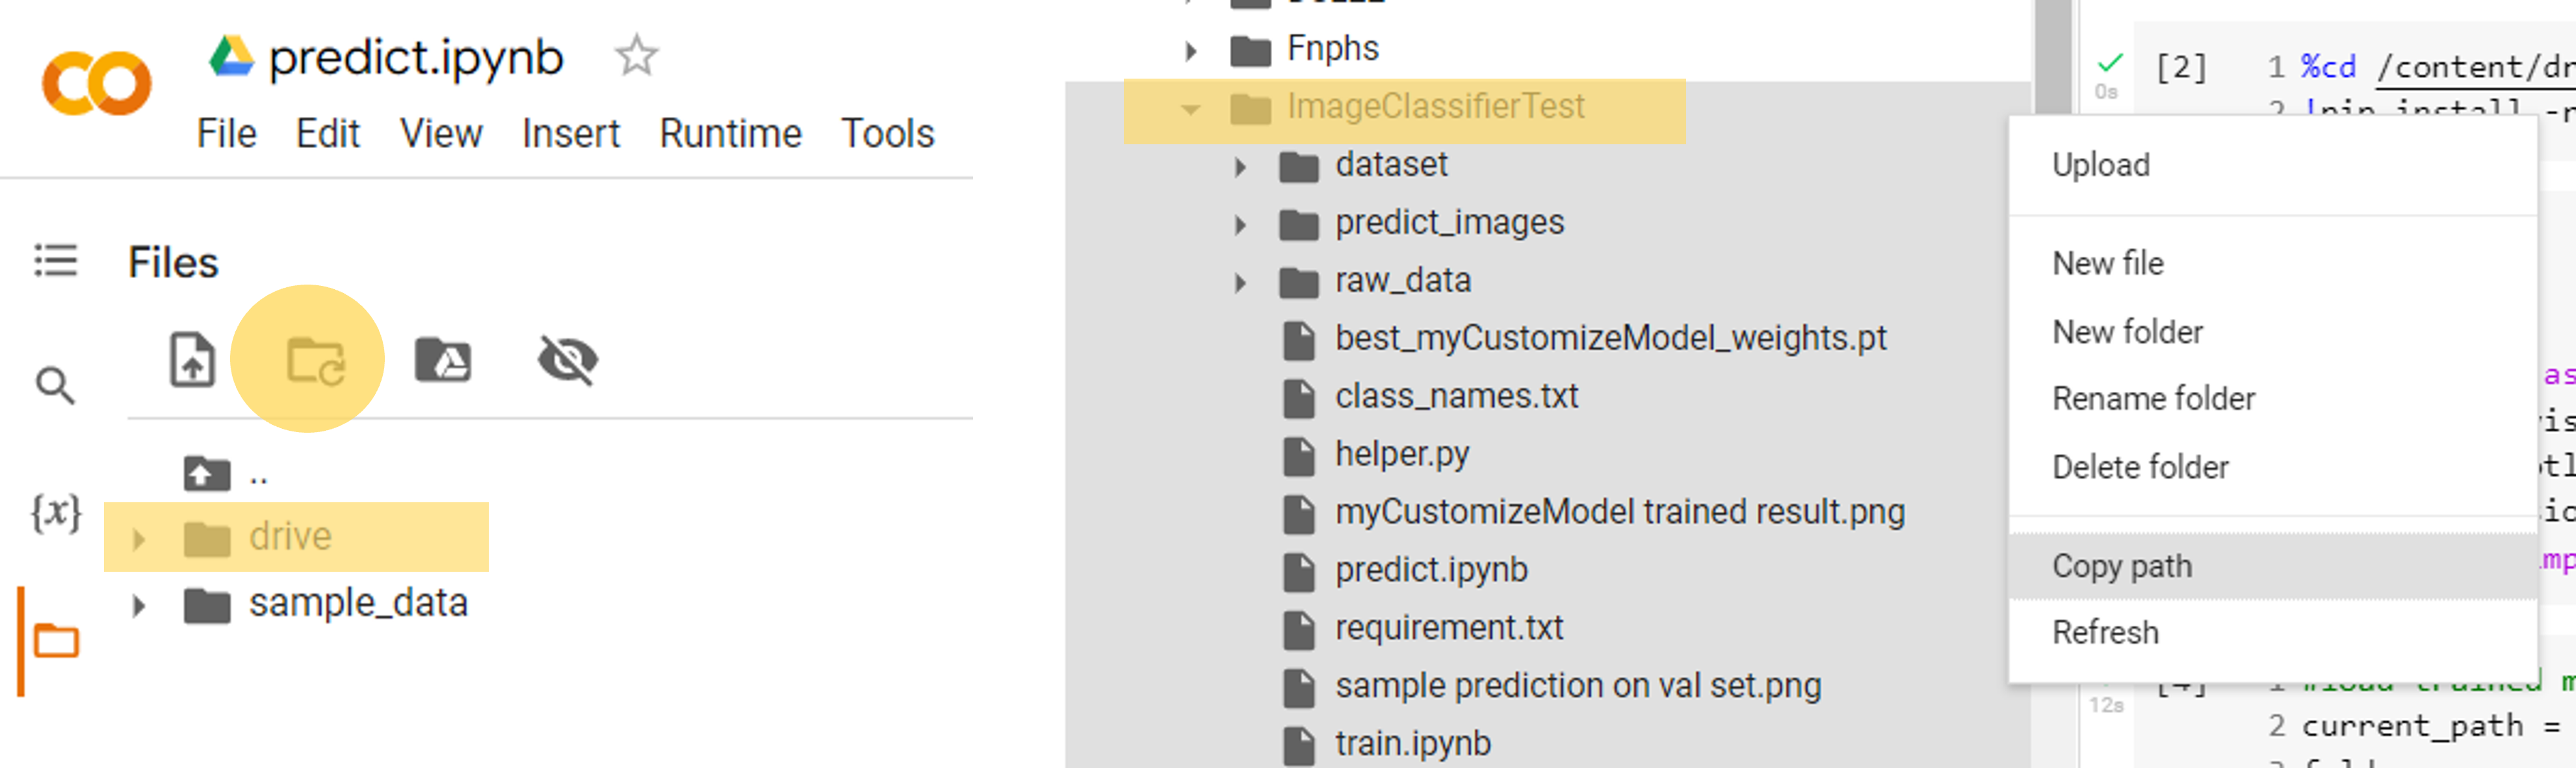

In [ ]:
# CHANGE YOUR DRIVE PATH HERE
%cd /content/drive/MyDrive/YOUR_FOLDER_THAT_HAVE_RAW_DATA_FOLDER
!pip install -r requirement.txt

In [ ]:
# import 
from torch import nn
import matplotlib, shutil
from random import shuffle
import os, torch, torchvision
from google.colab import files
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from helper import CreateDataFolder, device, train, test_one_epoch, predict, plot_predict, ToTensor, ToTensorShowImage

In [ ]:
device

## you can change Parameter here or **just click run**
- after this just click **run after** in Runtime

In [ ]:
# parameter
model_name = 'myCustomizeModel'
raw_data_dir = 'raw_data'
dataset_dir = 'dataset'
train_size = 0.7
val_size = 0.2
test_size = 0.1 # 0 if don't want to have test folder
hasTest = True # want to hasTest folder or not
train_path = f'{dataset_dir}/train'
val_path =  f'{dataset_dir}/val'
test_path =  f'{dataset_dir}/test'
batch_size = 32
epochs = 22
learning_rate = 0.001

### Clean data and Create dataset folder

In [ ]:
CreateDataFolder(raw_data_dir, dataset_dir, train_size, val_size, test_size, hasTest)

### Pretrain Model

In [ ]:
weigths = torchvision.models.EfficientNet_B2_Weights.DEFAULT
transfomer = weigths.transforms()
EB2_model = torchvision.models.efficientnet_b2(weights=weigths).to(device)

if  hasTest :
    train_images = datasets.ImageFolder(root=train_path, transform=transfomer)
    val_images = datasets.ImageFolder(root=val_path, transform=transfomer)
    test_images = datasets.ImageFolder(root=test_path, transform=transfomer)
    train_dataloader = DataLoader(train_images, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_images, batch_size=batch_size, shuffle=False)
    test_dataloader = DataLoader(test_images, batch_size=batch_size, shuffle=False)
    print(f'''
    train_loader has {len(train_dataloader)} batches 
    val_loader has {len(val_dataloader)} batches 
    test_loader has {len(test_dataloader)} batches''')
else :
    train_images = datasets.ImageFolder(root=train_path, transform=transfomer)
    val_images = datasets.ImageFolder(root=val_path, transform=transfomer)
    train_dataloader = DataLoader(train_images, batch_size=batch_size, shuffle=True)
    val_dataloader = DataLoader(val_images, batch_size=batch_size, shuffle=False)
    print(f'''
    train_loader has {len(train_dataloader)} batches 
    val_loader has {len(val_dataloader)} batches''')

class_names = train_images.classes
with open('class_names.txt', 'w') as f :
    for class_ in class_names :
        f.writelines(f'{class_}\n')
for param in EB2_model.features.parameters() :
    param.requires_grad = False # freeze
EB2_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), 
    torch.nn.Linear(in_features=1408, 
                    out_features=len(class_names), 
                    bias=True)).to(device)

### Training

In [ ]:
loss_fn = nn.CrossEntropyLoss() 
optimizer = torch.optim.Adam(EB2_model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', patience=5, factor=0.9, verbose=True)

In [ ]:
model_result = train(
    EB2_model, train_dataloader, val_dataloader, loss_fn, optimizer, epochs, scheduler, model_name, class_names
)

## Evaluation 

In [ ]:
trained_model = torchvision.models.efficientnet_b2().to(device)
trained_model.classifier = torch.nn.Sequential(
    torch.nn.Dropout(p=0.3, inplace=True), 
    torch.nn.Linear(in_features=1408, 
                    out_features=len(class_names), 
                    bias=True)).to(device)
trained_model.load_state_dict(torch.load(f=f'best_{model_name}_weights.pt', map_location=device))

acc, loss = test_one_epoch(trained_model, val_dataloader, loss_fn)
print(f'''
val_result :
    acc = {acc*100:.2f}%
    loss = {loss:.4f}
''')

if hasTest :
    acc, loss = test_one_epoch(trained_model, test_dataloader, loss_fn)
    print(f'''
test_result :
    acc = {acc*100:.2f}%
    loss = {loss:.4f}
    ''')

In [ ]:
epochs_ = [x+1 for x in range(epochs)]
matplotlib.rcParams.update({'font.size': 12, 'font.family' : 'sans-serif', 'font.weight': 'ultralight'})
plt.figure(figsize=(15,5))
plt.subplot(1,2,1)
plt.plot(epochs_, model_result['train_acc'], label='train', color='orange')
plt.plot(epochs_, model_result['val_acc'], label='val', color='violet')
plt.xlabel('epochs')
plt.ylabel('accuracy(%)')
plt.legend()
plt.grid(True)

plt.subplot(1,2,2)
plt.plot(epochs_, model_result['train_loss'], label='train', color='orange')
plt.plot(epochs_, model_result['val_loss'], label='val', color='violet')
plt.xlabel('epochs')
plt.ylabel('cross entropy loss')
plt.legend()
plt.grid(True)

set_ =  'test' if hasTest else 'val'
plt.suptitle(f'{model_name}\naccuracy on {set_} set = {acc*100:.2f}%', fontsize=14);
plt.savefig(f'{model_name} trained result.png');

## Prediction on val/test set

In [ ]:
path_ = test_path if hasTest else val_path
images_path = []
for class_ in os.listdir(path_) :
    class_path = os.path.join(path_, class_) 
    for image_name in os.listdir(class_path) :
        images_path.append(os.path.join(class_path, image_name))
shuffle(images_path)


idx = 0
acc = 0
images_row = 10 if len(images_path) >= 100 else int(len(images_path)**(1/2)) + 1
plt.figure(figsize=(images_row*3,3*images_row-3))
for image_path in images_path : 
    label = image_path.split('/')[2]
    p_image = ToTensor(image_path)
    s_image = ToTensorShowImage(image_path)
    plt.subplot(images_row, images_row, idx+1)
    pred_class, _ = predict(p_image, trained_model, class_names)
    color = 'black'
    if pred_class != label :
        color = 'red'
        add_title = f'{label}'
    else :
        acc += 1
        add_title = None
    plot_predict(p_image, trained_model, s_image, class_names, color, add_title)
    idx+=1
    if idx == 100 :
        break

acc /= idx
set_ =  'test' if hasTest else 'val'
plt.suptitle(f'sample prediction on {set_} set with {acc*100:.2f}% accuracy', fontsize=14, y=0.92)
plt.savefig(f'sample prediction on {set_} set.png');

### You can **close this file** then open **predict.ipynb** for prediction